In [1]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
# from tensorflow import keras as keras 

1.15.0
2.3.1


Using TensorFlow backend.


In [2]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('Dane/adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

# print(X_train.shape)
# X_test.shape

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="binary_crossentropy",optimizer=Adam, metrics=["accuracy"])

save_best_model = ModelCheckpoint("wagi_best.h5py",save_best_only=True)
lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[lrate, history_Adam, save_best_model, early_stopping])


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 100)               4200      
_________________________________________________________________
dense_14 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_15 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 11        
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________
Train on 30162 samples, validate on 15060 samples
Epoch 1/100
30162/30162 [==============================] - 2s 56us/step - loss: 0.5346 - accuracy: 0.7582 - val_loss: 0.5090 - val_accuracy: 0.7913
Epoch 2/100
30162/30162 [===========================

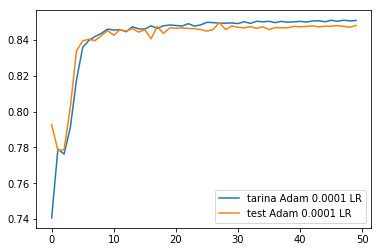

In [10]:
plt.plot(history_Adam.history['accuracy'], label = "tarina Adam 0.0001 LR")
plt.plot(history_Adam.history['val_accuracy'], label = "test Adam 0.0001 LR")


plt.legend()
plt.show()

In [10]:
model.load_weights("wagi_best.h5py")
model.evaluate(X_test,y_test)

15060/15060 [==============================] - 0s 13us/step


[0.3283151268127905, 0.8461487293243408]

# Zad.
Do poniższych danych dobierz paametr
```python
patience=
```

Zwizualizuj wyniki dla obu modeli.

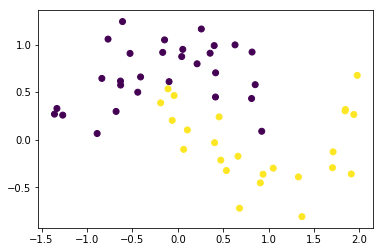

In [149]:
from sklearn.datasets import make_moons
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=5)
# split into train and test
# n_train = 30
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=2)

n_train=53
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

plt.scatter(X_train[:,0],X_train[:,1], c=y_train)
plt.show()

In [150]:
from keras.callbacks import History


history_Adam = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dense(500,activation="sigmoid"))
model.add(Dense(200,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam])


Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_200 (Dense)            (None, 1000)              3000      
_________________________________________________________________
dense_201 (Dense)            (None, 500)               500500    
_________________________________________________________________
dense_202 (Dense)            (None, 200)               100200    
_________________________________________________________________
dense_203 (Dense)            (None, 1)                 201       
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Train on 53 samples, validate on 47 samples
Epoch 1/1000
53/53 [==============================] - 1s 23ms/step - loss: 0.6985 - accuracy: 0.5472 - val_loss: 0.8858 - val_accuracy: 0.4468
Epoch 2/1000
53/53 [==============================] - 0s 9

53/53 [==============================] - 0s 809us/step - loss: 0.0767 - accuracy: 0.9811 - val_loss: 0.2404 - val_accuracy: 0.9149
Epoch 108/1000
53/53 [==============================] - 0s 922us/step - loss: 0.0785 - accuracy: 0.9811 - val_loss: 0.2333 - val_accuracy: 0.9149
Epoch 109/1000
53/53 [==============================] - 0s 847us/step - loss: 0.0729 - accuracy: 0.9811 - val_loss: 0.2176 - val_accuracy: 0.9149
Epoch 110/1000
53/53 [==============================] - 0s 809us/step - loss: 0.0763 - accuracy: 0.9811 - val_loss: 0.2107 - val_accuracy: 0.8936
Epoch 111/1000
53/53 [==============================] - 0s 828us/step - loss: 0.0741 - accuracy: 0.9811 - val_loss: 0.2259 - val_accuracy: 0.9149
Epoch 112/1000
53/53 [==============================] - 0s 790us/step - loss: 0.0667 - accuracy: 0.9811 - val_loss: 0.2318 - val_accuracy: 0.9149
Epoch 113/1000
53/53 [==============================] - 0s 847us/step - loss: 0.0657 - accuracy: 0.9811 - val_loss: 0.2249 - val_accuracy: 

53/53 [==============================] - 0s 790us/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.1856 - val_accuracy: 0.9362
Epoch 220/1000
53/53 [==============================] - 0s 809us/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.1859 - val_accuracy: 0.9149
Epoch 221/1000
53/53 [==============================] - 0s 828us/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.1870 - val_accuracy: 0.9149
Epoch 222/1000
53/53 [==============================] - 0s 809us/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.1871 - val_accuracy: 0.9149
Epoch 223/1000
53/53 [==============================] - 0s 790us/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.1889 - val_accuracy: 0.9149
Epoch 224/1000
53/53 [==============================] - 0s 1ms/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.1910 - val_accuracy: 0.9149
Epoch 225/1000
53/53 [==============================] - 0s 1ms/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.1930 - val_accuracy: 0.91

53/53 [==============================] - 0s 696us/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.2140 - val_accuracy: 0.9149
Epoch 332/1000
53/53 [==============================] - 0s 809us/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.2160 - val_accuracy: 0.9149
Epoch 333/1000
53/53 [==============================] - 0s 734us/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.2179 - val_accuracy: 0.9149
Epoch 334/1000
53/53 [==============================] - 0s 734us/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.2188 - val_accuracy: 0.9149
Epoch 335/1000
53/53 [==============================] - 0s 715us/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.2187 - val_accuracy: 0.9149
Epoch 336/1000
53/53 [==============================] - 0s 734us/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.2184 - val_accuracy: 0.9149
Epoch 337/1000
53/53 [==============================] - 0s 734us/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.2176 - val_accuracy: 

53/53 [==============================] - 0s 772us/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2498 - val_accuracy: 0.9149
Epoch 444/1000
53/53 [==============================] - 0s 866us/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2494 - val_accuracy: 0.9149
Epoch 445/1000
53/53 [==============================] - 0s 903us/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2470 - val_accuracy: 0.9149
Epoch 446/1000
53/53 [==============================] - 0s 772us/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2466 - val_accuracy: 0.9149
Epoch 447/1000
53/53 [==============================] - 0s 772us/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2459 - val_accuracy: 0.9149
Epoch 448/1000
53/53 [==============================] - 0s 790us/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2450 - val_accuracy: 0.9149
Epoch 449/1000
53/53 [==============================] - 0s 734us/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.2444 - val_accuracy: 

Epoch 554/1000
53/53 [==============================] - 0s 677us/step - loss: 7.4382e-04 - accuracy: 1.0000 - val_loss: 0.2694 - val_accuracy: 0.9149
Epoch 555/1000
53/53 [==============================] - 0s 753us/step - loss: 7.4078e-04 - accuracy: 1.0000 - val_loss: 0.2696 - val_accuracy: 0.9149
Epoch 556/1000
53/53 [==============================] - 0s 772us/step - loss: 7.3330e-04 - accuracy: 1.0000 - val_loss: 0.2701 - val_accuracy: 0.9149
Epoch 557/1000
53/53 [==============================] - 0s 753us/step - loss: 7.2875e-04 - accuracy: 1.0000 - val_loss: 0.2711 - val_accuracy: 0.9149
Epoch 558/1000
53/53 [==============================] - 0s 659us/step - loss: 7.2239e-04 - accuracy: 1.0000 - val_loss: 0.2719 - val_accuracy: 0.9149
Epoch 559/1000
53/53 [==============================] - 0s 734us/step - loss: 7.3076e-04 - accuracy: 1.0000 - val_loss: 0.2723 - val_accuracy: 0.9149
Epoch 560/1000
53/53 [==============================] - 0s 715us/step - loss: 7.5302e-04 - accuracy:

Epoch 663/1000
53/53 [==============================] - 0s 1ms/step - loss: 4.6905e-04 - accuracy: 1.0000 - val_loss: 0.2909 - val_accuracy: 0.9149
Epoch 664/1000
53/53 [==============================] - 0s 1ms/step - loss: 4.5624e-04 - accuracy: 1.0000 - val_loss: 0.2925 - val_accuracy: 0.9149
Epoch 665/1000
53/53 [==============================] - 0s 1ms/step - loss: 4.5163e-04 - accuracy: 1.0000 - val_loss: 0.2941 - val_accuracy: 0.9149
Epoch 666/1000
53/53 [==============================] - 0s 1ms/step - loss: 4.4907e-04 - accuracy: 1.0000 - val_loss: 0.2954 - val_accuracy: 0.9149
Epoch 667/1000
53/53 [==============================] - 0s 1ms/step - loss: 4.4846e-04 - accuracy: 1.0000 - val_loss: 0.2962 - val_accuracy: 0.9149
Epoch 668/1000
53/53 [==============================] - 0s 1ms/step - loss: 4.5418e-04 - accuracy: 1.0000 - val_loss: 0.2963 - val_accuracy: 0.9149
Epoch 669/1000
53/53 [==============================] - 0s 1ms/step - loss: 4.5004e-04 - accuracy: 1.0000 - val_

Epoch 773/1000
53/53 [==============================] - 0s 677us/step - loss: 3.0442e-04 - accuracy: 1.0000 - val_loss: 0.3137 - val_accuracy: 0.9149
Epoch 774/1000
53/53 [==============================] - 0s 677us/step - loss: 3.0750e-04 - accuracy: 1.0000 - val_loss: 0.3123 - val_accuracy: 0.9149
Epoch 775/1000
53/53 [==============================] - 0s 677us/step - loss: 3.2482e-04 - accuracy: 1.0000 - val_loss: 0.3119 - val_accuracy: 0.9149
Epoch 776/1000
53/53 [==============================] - 0s 677us/step - loss: 3.1250e-04 - accuracy: 1.0000 - val_loss: 0.3133 - val_accuracy: 0.9149
Epoch 777/1000
53/53 [==============================] - 0s 696us/step - loss: 3.0371e-04 - accuracy: 1.0000 - val_loss: 0.3152 - val_accuracy: 0.9149
Epoch 778/1000
53/53 [==============================] - 0s 696us/step - loss: 3.1720e-04 - accuracy: 1.0000 - val_loss: 0.3181 - val_accuracy: 0.9149
Epoch 779/1000
53/53 [==============================] - 0s 696us/step - loss: 2.9821e-04 - accuracy:

Epoch 882/1000
53/53 [==============================] - 0s 715us/step - loss: 2.2106e-04 - accuracy: 1.0000 - val_loss: 0.3308 - val_accuracy: 0.9149
Epoch 883/1000
53/53 [==============================] - 0s 677us/step - loss: 2.2155e-04 - accuracy: 1.0000 - val_loss: 0.3307 - val_accuracy: 0.9149
Epoch 884/1000
53/53 [==============================] - 0s 696us/step - loss: 2.1591e-04 - accuracy: 1.0000 - val_loss: 0.3319 - val_accuracy: 0.9149
Epoch 885/1000
53/53 [==============================] - 0s 696us/step - loss: 2.2040e-04 - accuracy: 1.0000 - val_loss: 0.3335 - val_accuracy: 0.9149
Epoch 886/1000
53/53 [==============================] - 0s 677us/step - loss: 2.1418e-04 - accuracy: 1.0000 - val_loss: 0.3339 - val_accuracy: 0.9149
Epoch 887/1000
53/53 [==============================] - 0s 677us/step - loss: 2.1207e-04 - accuracy: 1.0000 - val_loss: 0.3348 - val_accuracy: 0.9149
Epoch 888/1000
53/53 [==============================] - 0s 677us/step - loss: 2.1222e-04 - accuracy:

Epoch 991/1000
53/53 [==============================] - 0s 847us/step - loss: 1.6419e-04 - accuracy: 1.0000 - val_loss: 0.3487 - val_accuracy: 0.9149
Epoch 992/1000
53/53 [==============================] - 0s 809us/step - loss: 1.5845e-04 - accuracy: 1.0000 - val_loss: 0.3495 - val_accuracy: 0.9149
Epoch 993/1000
53/53 [==============================] - 0s 809us/step - loss: 1.5805e-04 - accuracy: 1.0000 - val_loss: 0.3502 - val_accuracy: 0.9149
Epoch 994/1000
53/53 [==============================] - 0s 772us/step - loss: 1.5767e-04 - accuracy: 1.0000 - val_loss: 0.3507 - val_accuracy: 0.9149
Epoch 995/1000
53/53 [==============================] - 0s 809us/step - loss: 1.5747e-04 - accuracy: 1.0000 - val_loss: 0.3509 - val_accuracy: 0.9149
Epoch 996/1000
53/53 [==============================] - 0s 866us/step - loss: 1.5889e-04 - accuracy: 1.0000 - val_loss: 0.3511 - val_accuracy: 0.9149
Epoch 997/1000
53/53 [==============================] - 0s 884us/step - loss: 1.5679e-04 - accuracy:

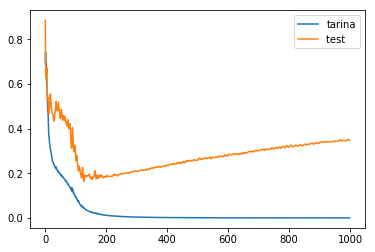

In [152]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")


plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


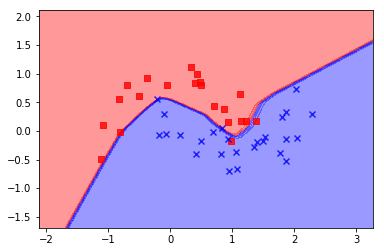

In [155]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()